# UMAP Performance Analysis: JavaScript vs WebAssembly Features

## Research Questions

**RQ1**: What is the performance impact of individual WASM features (Distance, Tree, Matrix, NN Descent, Optimizer) compared to pure JavaScript?

**RQ2**: How does enabling all WASM features together compare to individual features and pure JavaScript?

**RQ3**: How do machine characteristics affect the performance comparisons?

## Methodology

- **Baseline**: Pure JavaScript UMAP implementation (no WASM)
- **Individual Features**: Each WASM feature enabled separately (Dist, Tree, Matrix, NN, Opt)
- **All Features**: All WASM features enabled simultaneously
- **Metrics**: Runtime (ms), Memory (MB), Quality (trustworthiness), FPS, Responsiveness (ms)
- **Statistical Analysis**: Mann-Whitney U tests, bootstrap confidence intervals, effect sizes
- **Machine Normalization**: Within-machine comparisons to account for hardware differences

## 1. Setup and Data Loading

In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistical analysis
from scipy import stats
from scipy.stats import mannwhitneyu, bootstrap

# Set styling for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 3)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All dependencies loaded successfully")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

✓ All dependencies loaded successfully
  pandas: 2.3.3
  numpy: 2.4.1


In [35]:
# Load data
df = pd.read_csv('preprocessed.csv')

print(f"Total rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nSample of dataset_name and dataset_size:")
print(df[['dataset_name', 'dataset_size']].drop_duplicates().sort_values('dataset_name'))
print(f"\nDataset size statistics:")
print(df['dataset_size'].describe())
print(f"\nFirst few rows:")
df.head()

Total rows: 892
Columns: 35

Sample of dataset_name and dataset_size:
                             dataset_name  dataset_size
281         3D Dense Clusters (1K points)          1000
0           Iris Dataset (150 points, 4D)           150
280          MNIST-like (1K points, 784D)          1000
141         Medium Clustered (600 points)           600
1                Small Random (80 points)            80
140  Swiss Roll (600 points, 3D manifold)           600

Dataset size statistics:
count     892.000
mean      578.756
std       348.540
min        80.000
25%       150.000
50%       600.000
75%      1000.000
max      1000.000
Name: dataset_size, dtype: float64

First few rows:


,generated_at,runs_declared,result_run,result_wasm_features,result_duration_ms,stats_start_time,stats_duration_ms,wasm_features_file,wasm_preload,machine_platform,machine_release,machine_arch,cpu_model,cpu_cores,total_mem_bytes,load_avg_1,load_avg_5,load_avg_15,hostname,git_commit,git_branch,git_status_dirty,ui_run_id,ui_timestamp,scope,dataset_name,dataset_size,dimensions,ui_wasm_features,wasm_mode,runtime_ms,memory_delta_mb,trustworthiness,fps_avg,responsiveness_ms
0,2026-01-31T12:39:27.635Z,10,1,none,43526,2026-01-31T12:39:45.906Z,25293.620,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:40:03.865Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2326.9,-0.055,0.987,60.000,8.600
1,2026-01-31T12:39:27.635Z,10,1,none,43526,2026-01-31T12:39:45.906Z,25293.620,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,2,2026-01-31T12:40:11.571Z,small,Small Random (80 points),80,10,none,js,3404.4,-4.720,0.877,48.205,24.000
2,2026-01-31T12:39:27.635Z,10,2,none,45124,2026-01-31T12:40:27.525Z,28781.219,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:40:50.544Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2297.1,2.982,0.992,60.000,9.073
3,2026-01-31T12:39:27.635Z,10,2,none,45124,2026-01-31T12:40:27.525Z,28781.219,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,2,2026-01-31T12:40:56.801Z,small,Small Random (80 points),80,10,none,js,3291.8,14.747,0.831,48.000,22.900
4,2026-01-31T12:39:27.635Z,10,3,none,46734,2026-01-31T12:41:11.846Z,31195.437,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:41:36.835Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2334.0,1.220,0.989,59.994,9.882


## 2. Data Cleaning and Preparation

In [31]:
# Standardize column names and prepare data
df_clean = df.copy()

# Create standardized feature column
df_clean['feature'] = df_clean['result_wasm_features'].fillna('none').str.lower().str.strip()

# Standardize feature names
feature_map = {
    'none': 'Baseline (JS)',
    'dist': 'Distance',
    'tree': 'Tree',
    'matrix': 'Matrix',
    'nn': 'NN Descent',
    'opt': 'Optimizer',
    'all': 'All Features'
}
df_clean['feature_name'] = df_clean['feature'].map(feature_map)

# Identify machine types
df_clean['machine_type'] = df_clean['machine_platform'].map({
    'darwin': 'MacBook',
    'linux': 'Linux'
})

# Convert numeric columns
numeric_cols = ['runtime_ms', 'memory_delta_mb', 'trustworthiness', 'fps_avg', 'responsiveness_ms']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Remove missing values in key columns
df_clean = df_clean.dropna(subset=['runtime_ms', 'feature_name', 'machine_type'])

print(f"\nAfter cleaning: {len(df_clean):,} rows")
print(f"\nFeature distribution:")
print(df_clean['feature_name'].value_counts().sort_index())
print(f"\nMachine distribution:")
print(df_clean['machine_type'].value_counts())
print(f"\nDataset distribution:")
print(df_clean['dataset_name'].value_counts())


After cleaning: 892 rows

Feature distribution:
feature_name
All Features     120
Baseline (JS)    110
Distance         120
Matrix           140
NN Descent       140
Optimizer        140
Tree             122
Name: count, dtype: int64

Machine distribution:
machine_type
MacBook    472
Linux      420
Name: count, dtype: int64

Dataset distribution:
dataset_name
Medium Clustered (600 points)           171
Swiss Roll (600 points, 3D manifold)    171
MNIST-like (1K points, 784D)            140
3D Dense Clusters (1K points)           140
Small Random (80 points)                135
Iris Dataset (150 points, 4D)           135
Name: count, dtype: int64


In [32]:
# Check for outliers and data quality
print("Data Quality Checks:")
print(f"Negative runtime values: {(df_clean['runtime_ms'] < 0).sum()}")
print(f"Trustworthiness out of range [0,1]: {(~df_clean['trustworthiness'].between(0, 1)).sum()}")
print(f"Negative FPS: {(df_clean['fps_avg'] < 0).sum()}")
print(f"\nRuntime statistics by feature:")
df_clean.groupby('feature_name')['runtime_ms'].describe()

Data Quality Checks:
Negative runtime values: 0
Trustworthiness out of range [0,1]: 0
Negative FPS: 0

Runtime statistics by feature:


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
All Features,120.0,1846.784,1134.506,461.8,721.625,1828.00,2533.450,4041.4
Baseline (JS),110.0,3645.283,855.738,2297.1,2955.350,3505.25,4513.300,5247.7
Distance,120.0,3542.208,846.813,2291.4,2857.325,3473.30,4479.825,5299.0
Matrix,140.0,3567.262,872.823,2283.7,2897.625,3473.55,4222.975,6979.8
NN Descent,140.0,3611.913,806.108,2289.9,2918.975,3615.25,4344.150,5229.2
Optimizer,140.0,1796.609,1084.715,460.6,738.050,1693.65,2488.950,3967.2
Tree,122.0,3575.258,886.322,2288.5,2875.600,3282.15,4492.675,5270.5


## 3. Machine-Specific Analysis

Since benchmarks were run on two different machines (MacBook and Linux), we need to analyze them separately to avoid confounding effects.

In [33]:
# Summary statistics by machine and feature
machine_summary = df_clean.groupby(['machine_type', 'feature_name']).agg({
    'runtime_ms': ['count', 'mean', 'std', 'median', 'min', 'max'],
    'memory_delta_mb': ['mean', 'median'],
    'trustworthiness': ['mean', 'median'],
    'fps_avg': ['mean', 'median'],
    'responsiveness_ms': ['mean', 'median']
}).round(2)

print("Performance by Machine and Feature:")
machine_summary

Performance by Machine and Feature:


runtime_ms                                            memory_delta_mb         \
                                count     mean      std   median     min     max            mean median   
machine_type feature_name                                                                                 
Linux        All Features          60  2156.65  1244.35  2272.45   609.4  4041.4           10.73  12.18   
             Baseline (JS)         60  3574.62   854.39  3559.85  2297.1  4832.7           11.61  13.57   
             Distance              60  3526.28   865.77  3360.75  2291.4  4894.3           12.49  14.02   
             Matrix                60  3586.41  1029.93  3492.45  2283.7  6979.8           13.06  10.82   
             NN Descent            60  3555.92   884.90  3498.30  2289.9  4907.4           17.04  14.17   
             Optimizer             60  2143.77  1257.78  2088.40   590.2  3967.2            5.30   2.02   
             Tree                  60  3517.93   888.43  3340.90  2288.5  4796.4           17.19  14.82   
MacBook      All Features          60  1536.92   923.22  1205.10   461.8  2827.4           15.38  16.28   
             Baseline (JS)         50  3730.08   858.23  3505.25  2395.1  5247.7           13.98  17.98   
             Distance              60  3558.13   834.42  3473.30  2519.2  5299.0           11.22  12.18   
             Matrix                80  3552.90   740.08  3473.55  2487.7  5262.8           14.71  13.95   
             NN Descent            80  3653.91   744.55  3619.90  2557.4  5229.2           15.34  17.29   
             Optimizer             80  1536.24   853.54  1223.30   460.6  2899.9           14.83  19.33   
             Tree                  62  3630.74   887.95  3282.15  2563.0  5270.5           13.88  13.45   

                           trustworthiness        fps_avg         responsiveness_ms         
                                      mean median    mean  median              mean median  
machine_type feature_name                                                                   
Linux        All Features             0.89   0.97   28.52   37.57             33.94  20.70  
             Baseline (JS)            0.90   0.97   54.91   56.44             36.89  22.49  
             Distance                 0.90   0.97   55.19   56.99             36.70  21.53  
             Matrix                   0.90   0.97   54.92   56.92             34.29  20.79  
             NN Descent               0.90   0.97   54.99   57.02             36.13  21.82  
             Optimizer                0.89   0.97   27.91   37.84             35.93  22.05  
             Tree                     0.90   0.97   55.17   56.93             35.78  22.04  
MacBook      All Features             0.89   0.97   54.48   62.70             18.57   6.32  
             Baseline (JS)            0.90   0.97  115.63  117.41             20.22   8.37  
             Distance                 0.90   0.97  115.20  116.84             17.18   7.35  
             Matrix                   0.92   0.97  115.64  117.02             15.12   6.63  
             NN Descent               0.92   0.97  115.48  116.45             14.18   7.26  
             Optimizer                0.91   0.97   61.66   65.03             17.66   8.05  
             Tree                     0.90   0.97  115.46  116.48             17.35   7.57

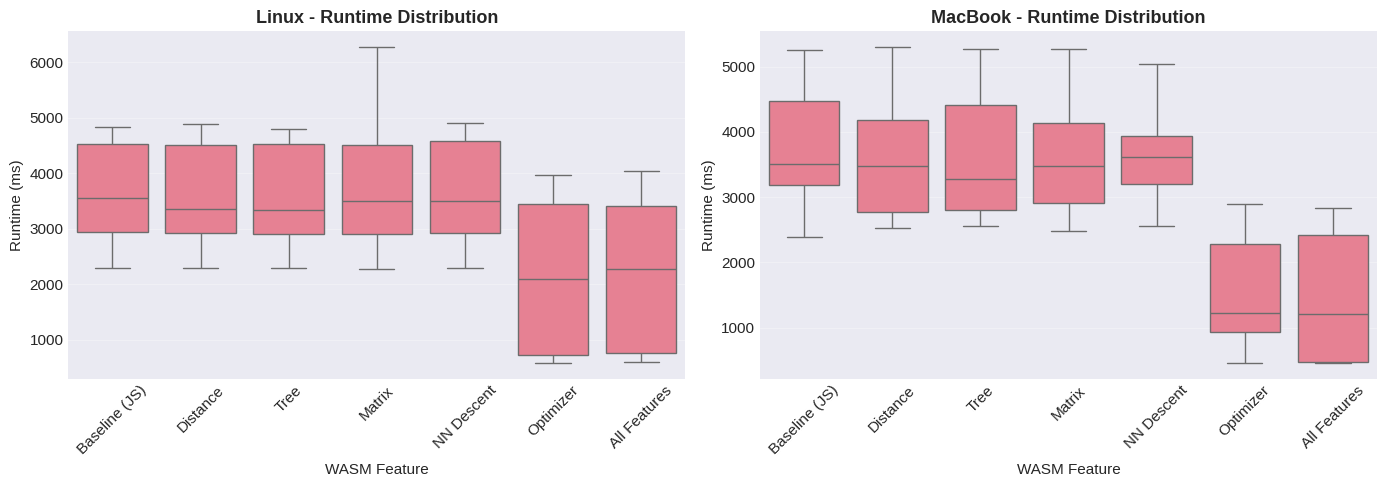

Note: MacBook shows faster absolute times, but relative comparisons should be done within each machine.


In [34]:
# Visualize machine differences
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, machine in enumerate(['Linux', 'MacBook']):
    machine_data = df_clean[df_clean['machine_type'] == machine]
    
    # Order features logically
    feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
    feature_order = [f for f in feature_order if f in machine_data['feature_name'].unique()]
    
    sns.boxplot(data=machine_data, x='feature_name', y='runtime_ms', 
                order=feature_order, ax=axes[idx], showfliers=False)
    axes[idx].set_title(f'{machine} - Runtime Distribution', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('WASM Feature', fontsize=11)
    axes[idx].set_ylabel('Runtime (ms)', fontsize=11)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('analysis_outputs/runtime_by_machine.png', bbox_inches='tight')
plt.show()

print("Note: MacBook shows faster absolute times, but relative comparisons should be done within each machine.")

## 4. Baseline Comparison: Pure JS vs Individual Features

Analyze each WASM feature individually against the baseline JavaScript implementation.

In [7]:
def calculate_speedup(df, baseline_feature='Baseline (JS)', machine=None):
    """
    Calculate speedup relative to baseline for each machine/dataset combination.
    """
    results = []
    
    # Filter by machine if specified
    data = df[df['machine_type'] == machine] if machine else df
    
    # Group by dataset and machine
    for (dataset, mach), group in data.groupby(['dataset_name', 'machine_type']):
        baseline = group[group['feature_name'] == baseline_feature]['runtime_ms']
        
        if len(baseline) == 0:
            continue
            
        baseline_median = baseline.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline_feature:
                continue
                
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset': dataset,
                'machine': mach,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

# Calculate speedups
speedup_df = calculate_speedup(df_clean)

print("Speedup Summary (all datasets and machines):")
speedup_summary = speedup_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std', 'min', 'max'],
    'improvement_pct': ['mean', 'median']
}).round(3)
speedup_summary

Speedup Summary (all datasets and machines):


speedup                             improvement_pct        
                mean median    std    min    max            mean  median
feature                                                                 
All Features   2.744  1.765  1.625  1.194  5.733         174.419  76.503
Distance       1.002  0.998  0.036  0.971  1.107           0.245  -0.188
Matrix         1.008  1.003  0.041  0.964  1.123           0.837   0.307
NN Descent     0.988  0.987  0.048  0.911  1.115          -1.241  -1.305
Optimizer      2.760  1.727  1.643  1.188  5.644         175.992  72.651
Tree           0.992  0.995  0.046  0.923  1.111          -0.782  -0.501

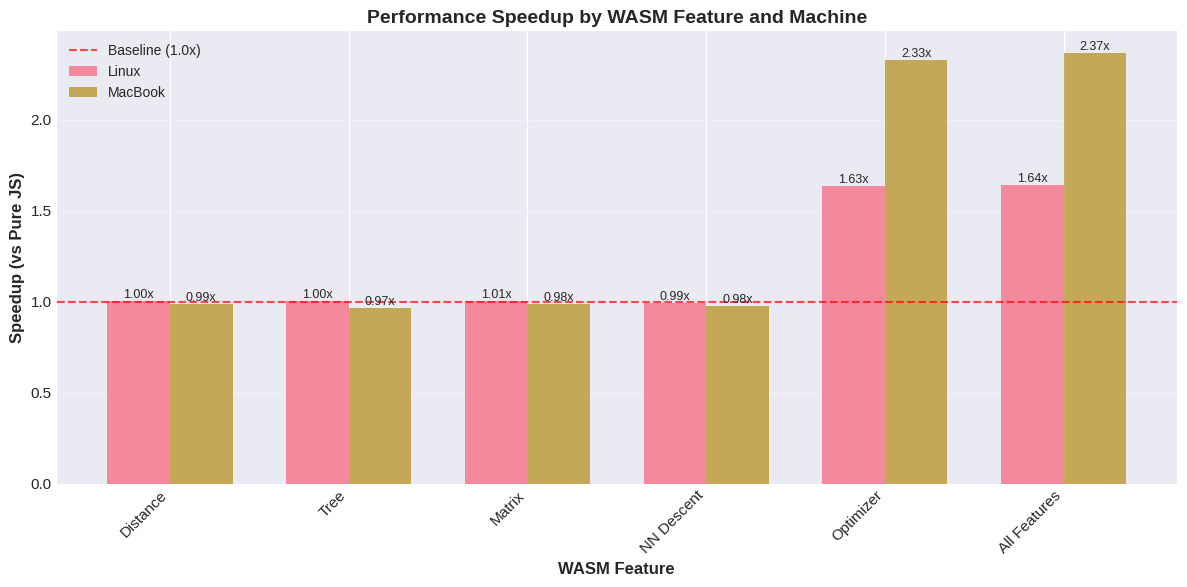

In [8]:
# Detailed speedup by feature and machine
feature_order = ['Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in speedup_df['feature'].unique()]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(feature_order))
width = 0.35

for i, machine in enumerate(['Linux', 'MacBook']):
    machine_speedups = speedup_df[speedup_df['machine'] == machine].groupby('feature')['speedup'].median()
    values = [machine_speedups.get(f, 0) for f in feature_order]
    
    offset = width * (i - 0.5)
    bars = ax.bar(x + offset, values, width, label=machine, alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}x',
                   ha='center', va='bottom', fontsize=9)

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, label='Baseline (1.0x)', alpha=0.7)
ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup (vs Pure JS)', fontsize=12, fontweight='bold')
ax.set_title('Performance Speedup by WASM Feature and Machine', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(feature_order, rotation=45, ha='right')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('analysis_outputs/speedup_comparison.png', bbox_inches='tight')
plt.show()

## 4.5. Dataset Size Analysis

Analyze how performance scales with dataset size and whether WASM features show different benefits for small vs large datasets.

In [29]:
# Extract dataset size information from the existing 'dataset_size' column
# This column is already in the CSV from the benchmark runs
df_clean['dataset_size'] = pd.to_numeric(df_clean['dataset_size'], errors='coerce')

# Benchmark dataset sizes:
# Small scope: Iris (150), Small Random (80)
# Mid scope: Swiss Roll (600), Medium Clustered (600)
# Large scope: MNIST-like (1000), 3D Dense Clusters (1000)

# Create size categories based on actual benchmark dataset sizes
df_clean['size_category'] = pd.cut(
    df_clean['dataset_size'], 
    bins=[0, 200, 800, float('inf')],
    labels=['Small (≤200)', 'Medium (200-800)', 'Large (>800)']
)

print("Dataset Size Distribution:")
print(df_clean.groupby('dataset_name')['dataset_size'].first().sort_values())
print(f"\nSize category distribution:")
print(df_clean['size_category'].value_counts().sort_index())

Dataset Size Distribution:
dataset_name
Iris Dataset (150 points, 4D)           135
Small Random (80 points)                135
MNIST-like (1K points, 784D)            140
3D Dense Clusters (1K points)           140
Medium Clustered (600 points)           171
Swiss Roll (600 points, 3D manifold)    171
Name: dataset_size, dtype: int64

Size category distribution:
size_category
Small (≤200)        892
Medium (200-800)      0
Large (>800)          0
Name: count, dtype: int64


In [10]:
# Analyze runtime by dataset size and feature
size_performance = df_clean.groupby(['dataset_name', 'dataset_size', 'feature_name', 'machine_type']).agg({
    'runtime_ms': ['mean', 'median', 'std', 'count']
}).round(2)

print("Runtime by Dataset Size and Feature:")
print("\nSummary statistics:")
size_summary = df_clean.groupby(['dataset_size', 'feature_name']).agg({
    'runtime_ms': ['mean', 'median', 'std']
}).round(2)
size_summary

Runtime by Dataset Size and Feature:

Summary statistics:


runtime_ms                 
                                 mean   median     std
dataset_size feature_name                             
135          All Features      593.40   545.20  135.16
             Baseline (JS)    2724.16  2623.05  412.90
             Distance         2655.80  2682.35  241.79
             Matrix           2643.64  2655.60  251.93
             NN Descent       2670.70  2717.70  266.27
             Optimizer         580.90   539.10  125.80
             Tree             2685.63  2762.25  246.93
140          All Features     3111.51  3093.85  613.45
             Baseline (JS)    4635.40  4592.55  279.46
             Distance         4593.35  4569.50  286.39
             Matrix           4655.22  4570.45  546.52
             NN Descent       4662.26  4648.50  276.22
             Optimizer        3155.74  3152.40  577.73
             Tree             4709.36  4612.00  293.94
171          All Features     1835.44  1988.65  529.91
             Baseline (JS)    3346.01  3337.15  302.96
             Distance         3377.48  3473.30  283.98
             Matrix           3457.71  3473.55  402.94
             NN Descent       3539.15  3615.25  282.28
             Optimizer        1701.00  1693.65  526.53
             Tree             3342.42  3282.15  309.37

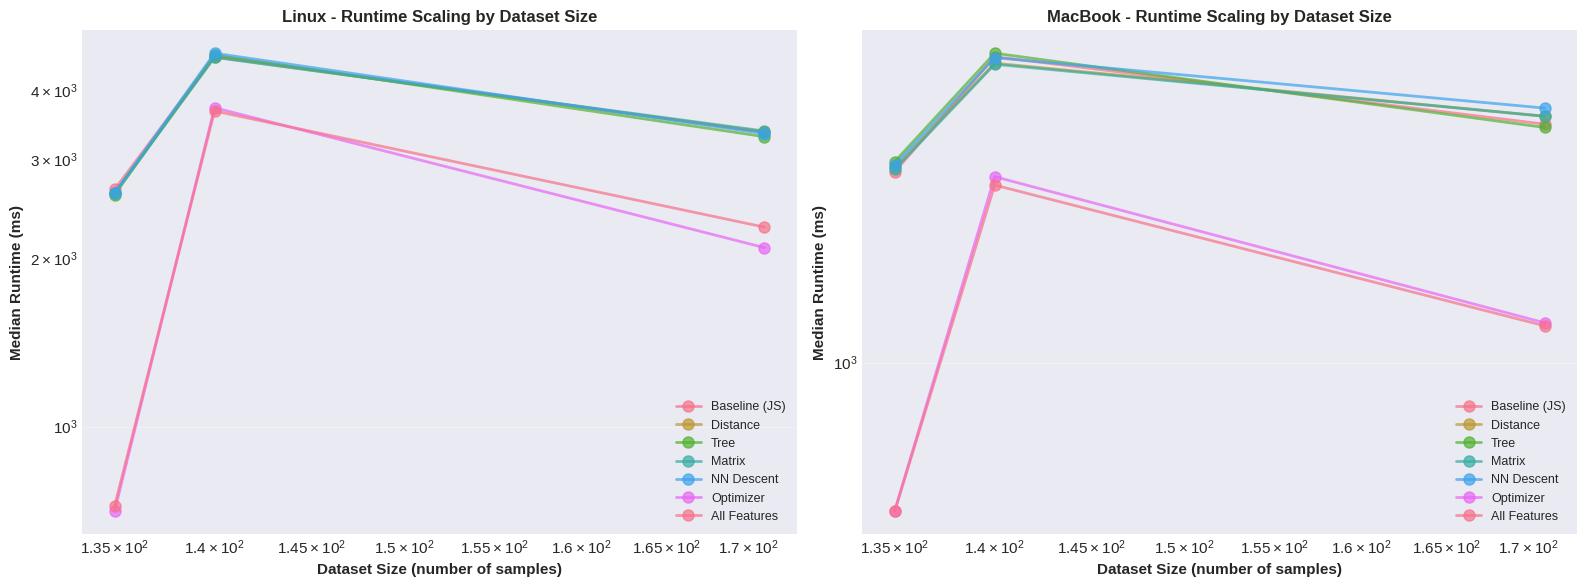

Note: Log-log scale used to show scaling behavior across different dataset sizes.


In [11]:
# Visualize runtime scaling with dataset size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_clean['feature_name'].unique()]

for idx, machine in enumerate(['Linux', 'MacBook']):
    machine_data = df_clean[df_clean['machine_type'] == machine]
    
    for feature in feature_order:
        feature_data = machine_data[machine_data['feature_name'] == feature]
        if len(feature_data) == 0:
            continue
        
        # Group by dataset size and calculate median runtime
        size_runtime = feature_data.groupby('dataset_size')['runtime_ms'].median().sort_index()
        
        axes[idx].plot(size_runtime.index, size_runtime.values, 
                      marker='o', label=feature, linewidth=2, markersize=8, alpha=0.7)
    
    axes[idx].set_xlabel('Dataset Size (number of samples)', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Median Runtime (ms)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{machine} - Runtime Scaling by Dataset Size', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9, loc='best')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xscale('log')
    axes[idx].set_yscale('log')

plt.tight_layout()
plt.savefig('analysis_outputs/runtime_scaling_by_size.png', bbox_inches='tight')
plt.show()

print("Note: Log-log scale used to show scaling behavior across different dataset sizes.")

In [12]:
# Analyze speedup by dataset size
def calculate_speedup_by_size(df, baseline_feature='Baseline (JS)'):
    """
    Calculate speedup relative to baseline for each dataset size.
    """
    results = []
    
    for (size, machine), group in df.groupby(['dataset_size', 'machine_type']):
        baseline = group[group['feature_name'] == baseline_feature]['runtime_ms']
        
        if len(baseline) == 0:
            continue
            
        baseline_median = baseline.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline_feature:
                continue
                
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset_size': size,
                'machine': machine,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

speedup_by_size_df = calculate_speedup_by_size(df_clean)

print("Speedup by Dataset Size:")
print("\nAverage speedup across size categories:")
speedup_summary_by_size = speedup_by_size_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std'],
    'improvement_pct': ['mean', 'median']
}).round(3)
speedup_summary_by_size

Speedup by Dataset Size:

Average speedup across size categories:


speedup               improvement_pct         
                mean median    std            mean   median
feature                                                    
All Features   2.775  2.341  1.631         177.534  134.112
Distance       0.998  1.001  0.026          -0.153    0.147
Matrix         1.001  1.000  0.027           0.059    0.002
NN Descent     0.984  0.996  0.035          -1.633   -0.356
Optimizer      2.784  2.281  1.626         178.435  128.065
Tree           0.998  1.006  0.028          -0.232    0.627

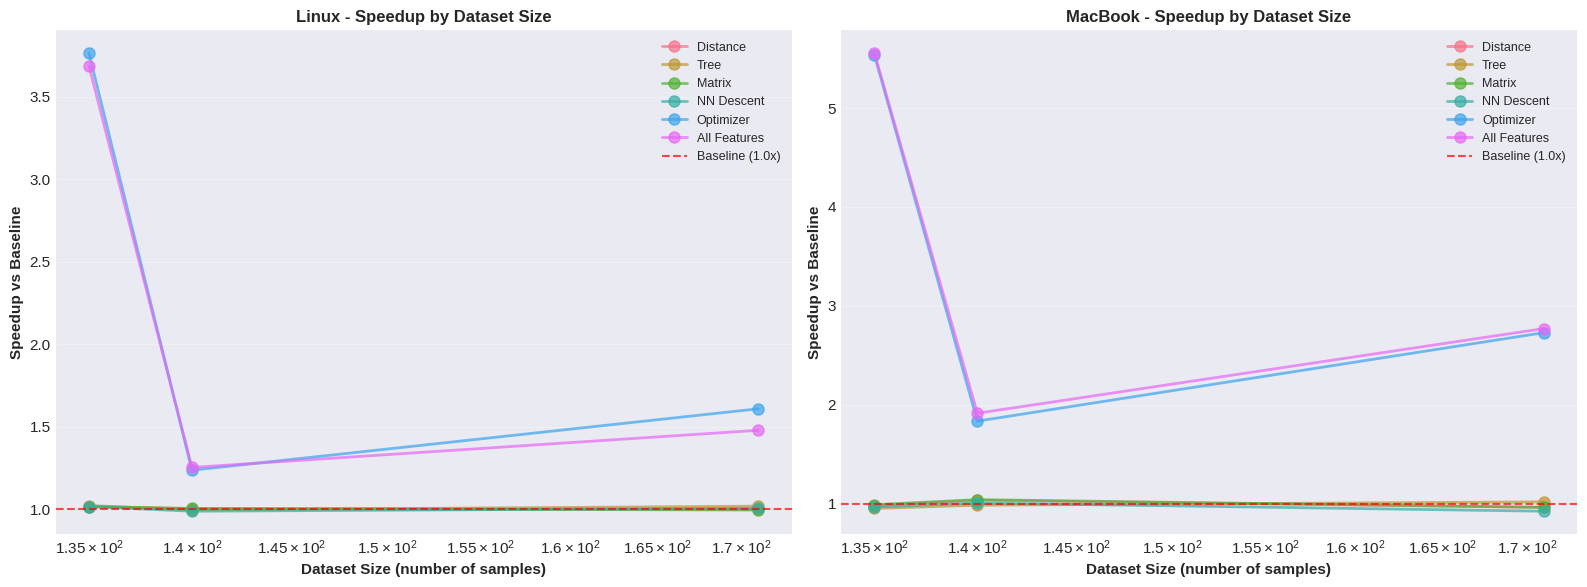

Note: Shows whether WASM benefits increase or decrease with dataset size.


In [13]:
# Visualize speedup trends by dataset size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

feature_order = ['Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in speedup_by_size_df['feature'].unique()]

for idx, machine in enumerate(['Linux', 'MacBook']):
    machine_data = speedup_by_size_df[speedup_by_size_df['machine'] == machine]
    
    for feature in feature_order:
        feature_data = machine_data[machine_data['feature'] == feature]
        if len(feature_data) == 0:
            continue
        
        # Sort by dataset size
        feature_data = feature_data.sort_values('dataset_size')
        
        axes[idx].plot(feature_data['dataset_size'], feature_data['speedup'], 
                      marker='o', label=feature, linewidth=2, markersize=8, alpha=0.7)
    
    axes[idx].axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Baseline (1.0x)')
    axes[idx].set_xlabel('Dataset Size (number of samples)', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Speedup vs Baseline', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{machine} - Speedup by Dataset Size', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9, loc='best')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_xscale('log')

plt.tight_layout()
plt.savefig('analysis_outputs/speedup_by_dataset_size.png', bbox_inches='tight')
plt.show()

print("Note: Shows whether WASM benefits increase or decrease with dataset size.")

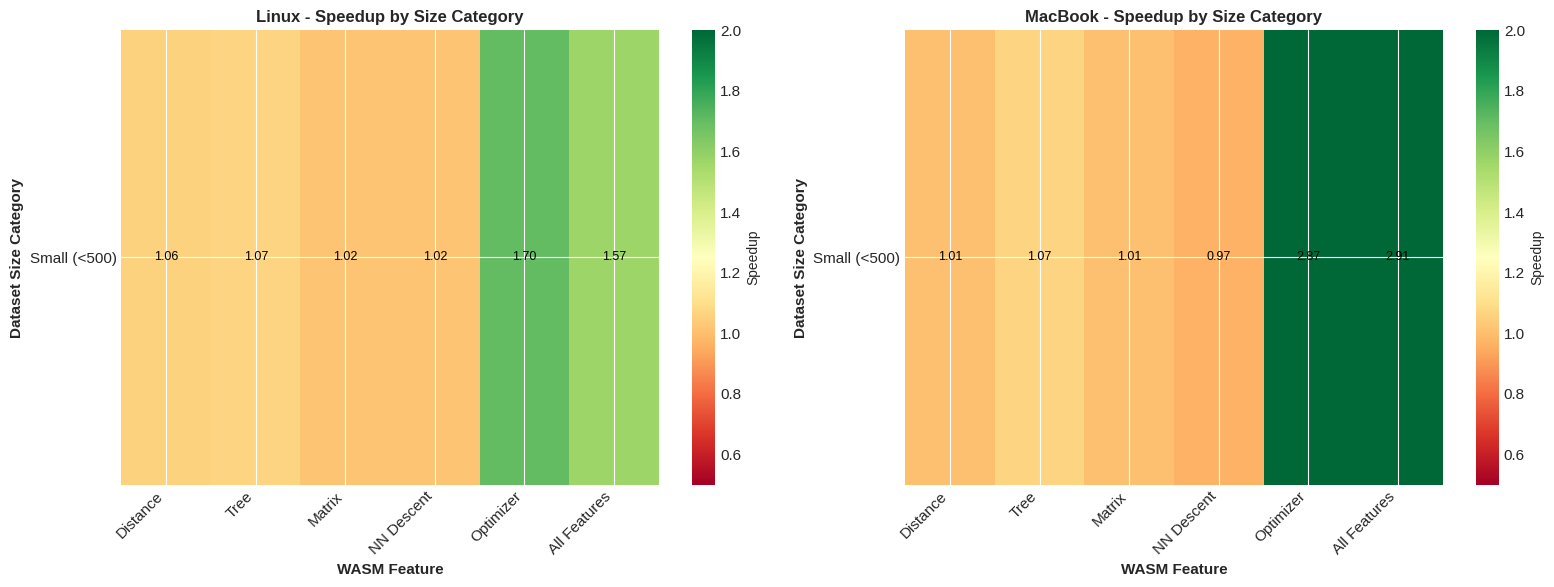

Note: Green = faster than baseline, Red = slower than baseline


In [14]:
# Heatmap of speedup by size category and feature
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, machine in enumerate(['Linux', 'MacBook']):
    machine_data = df_clean[df_clean['machine_type'] == machine]
    
    # Calculate speedup for each size category and feature
    speedup_matrix = []
    size_cats = machine_data['size_category'].dropna().unique()
    size_cats = sorted(size_cats, key=lambda x: ['Small (<500)', 'Medium (500-2K)', 'Large (2K-10K)', 'Very Large (>10K)'].index(x) if x in ['Small (<500)', 'Medium (500-2K)', 'Large (2K-10K)', 'Very Large (>10K)'] else 999)
    
    for size_cat in size_cats:
        size_data = machine_data[machine_data['size_category'] == size_cat]
        baseline = size_data[size_data['feature_name'] == 'Baseline (JS)']['runtime_ms'].median()
        
        if pd.isna(baseline) or baseline == 0:
            continue
        
        row = []
        for feature in feature_order:
            feature_data = size_data[size_data['feature_name'] == feature]
            if len(feature_data) > 0:
                speedup = baseline / feature_data['runtime_ms'].median()
                row.append(speedup)
            else:
                row.append(np.nan)
        
        if row:
            speedup_matrix.append(row)
    
    if speedup_matrix:
        speedup_matrix = np.array(speedup_matrix)
        
        im = axes[idx].imshow(speedup_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=2.0)
        axes[idx].set_xticks(np.arange(len(feature_order)))
        axes[idx].set_yticks(np.arange(len(size_cats[:len(speedup_matrix)])))
        axes[idx].set_xticklabels(feature_order, rotation=45, ha='right')
        axes[idx].set_yticklabels(size_cats[:len(speedup_matrix)])
        axes[idx].set_title(f'{machine} - Speedup by Size Category', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('WASM Feature', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Dataset Size Category', fontsize=11, fontweight='bold')
        
        # Add text annotations
        for i in range(len(speedup_matrix)):
            for j in range(len(feature_order)):
                if not np.isnan(speedup_matrix[i, j]):
                    text = axes[idx].text(j, i, f'{speedup_matrix[i, j]:.2f}',
                                        ha="center", va="center", color="black", fontsize=9)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[idx])
        cbar.set_label('Speedup', fontsize=10)

plt.tight_layout()
plt.savefig('analysis_outputs/speedup_heatmap_by_size.png', bbox_inches='tight')
plt.show()

print("Note: Green = faster than baseline, Red = slower than baseline")

In [15]:
# Summary statistics: Speedup by size category
print("=" * 80)
print("DATASET SIZE ANALYSIS SUMMARY")
print("=" * 80)

for machine in df_clean['machine_type'].unique():
    print(f"\n{machine} Machine:")
    print("-" * 60)
    
    machine_data = speedup_by_size_df[speedup_by_size_df['machine'] == machine]
    
    # Group by feature and calculate statistics
    size_analysis = machine_data.groupby('feature').agg({
        'speedup': ['mean', 'median', 'min', 'max', 'std']
    }).round(3)
    
    print(size_analysis)
    
    # Find which features scale better with size
    print(f"\nScaling behavior:")
    for feature in machine_data['feature'].unique():
        feat_data = machine_data[machine_data['feature'] == feature].sort_values('dataset_size')
        if len(feat_data) > 1:
            # Simple trend: compare smallest vs largest
            small_speedup = feat_data.iloc[0]['speedup']
            large_speedup = feat_data.iloc[-1]['speedup']
            trend = "improves" if large_speedup > small_speedup else "degrades"
            print(f"  {feature}: {trend} with size ({small_speedup:.2f}x → {large_speedup:.2f}x)")

print("\n" + "=" * 80)

DATASET SIZE ANALYSIS SUMMARY

Linux Machine:
------------------------------------------------------------
             speedup                            
                mean median    min    max    std
feature                                         
All Features   2.138  1.478  1.253  3.684  1.343
Distance       1.006  1.003  0.999  1.016  0.009
Matrix         1.005  1.005  0.995  1.016  0.010
NN Descent     1.003  1.006  0.988  1.016  0.014
Optimizer      2.202  1.608  1.236  3.762  1.364
Tree           1.012  1.019  0.996  1.022  0.014

Scaling behavior:
  All Features: degrades with size (3.68x → 1.48x)
  Distance: degrades with size (1.02x → 1.00x)
  Tree: degrades with size (1.02x → 1.02x)
  Matrix: degrades with size (1.02x → 1.00x)
  NN Descent: degrades with size (1.02x → 1.01x)
  Optimizer: degrades with size (3.76x → 1.61x)

MacBook Machine:
------------------------------------------------------------
             speedup                            
                mean m

## 5. Statistical Testing

Perform rigorous statistical tests to determine if differences are significant.

In [16]:
def mann_whitney_test(df, baseline_feature='Baseline (JS)'):
    """
    Perform Mann-Whitney U test comparing each feature to baseline.
    """
    results = []
    
    for machine in df['machine_type'].unique():
        machine_data = df[df['machine_type'] == machine]
        baseline = machine_data[machine_data['feature_name'] == baseline_feature]['runtime_ms'].dropna()
        
        if len(baseline) < 3:
            continue
        
        for feature in machine_data['feature_name'].unique():
            if feature == baseline_feature:
                continue
            
            feature_data = machine_data[machine_data['feature_name'] == feature]['runtime_ms'].dropna()
            
            if len(feature_data) < 3:
                continue
            
            # Mann-Whitney U test
            statistic, p_value = mannwhitneyu(baseline, feature_data, alternative='two-sided')
            
            # Effect size (Cohen's d approximation)
            mean_diff = feature_data.mean() - baseline.mean()
            pooled_std = np.sqrt((baseline.std()**2 + feature_data.std()**2) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
            
            # Cliff's Delta (effect size for non-parametric test)
            n1, n2 = len(baseline), len(feature_data)
            pairs_greater = sum(1 for b in baseline for f in feature_data if b > f)
            pairs_less = sum(1 for b in baseline for f in feature_data if b < f)
            cliffs_delta = (pairs_greater - pairs_less) / (n1 * n2)
            
            results.append({
                'machine': machine,
                'feature': feature,
                'n_baseline': len(baseline),
                'n_feature': len(feature_data),
                'baseline_median': baseline.median(),
                'feature_median': feature_data.median(),
                'p_value': p_value,
                'significant': p_value < 0.05,
                'cohens_d': cohens_d,
                'cliffs_delta': cliffs_delta
            })
    
    return pd.DataFrame(results)

# Perform tests
test_results = mann_whitney_test(df_clean)

print("Statistical Test Results (Mann-Whitney U Test):")
print("\nSignificance: p < 0.05")
print("Cliff's Delta interpretation: |δ| < 0.147 (negligible), < 0.33 (small), < 0.474 (medium), >= 0.474 (large)\n")
test_results.round(4)

Statistical Test Results (Mann-Whitney U Test):

Significance: p < 0.05
Cliff's Delta interpretation: |δ| < 0.147 (negligible), < 0.33 (small), < 0.474 (medium), >= 0.474 (large)



,machine,feature,n_baseline,n_feature,baseline_median,feature_median,p_value,significant,cohens_d,cliffs_delta
0,Linux,All Features,60,60,3559.85,2272.45,0.000,True,-1.329,0.571
1,Linux,Distance,60,60,3559.85,3360.75,0.633,False,-0.056,0.051
2,Linux,Tree,60,60,3559.85,3340.90,0.470,False,-0.065,0.077
3,Linux,Matrix,60,60,3559.85,3492.45,0.470,False,0.013,0.077
4,Linux,NN Descent,60,60,3559.85,3498.30,0.985,False,-0.021,0.002
5,Linux,Optimizer,60,60,3559.85,2088.40,0.000,True,-1.331,0.563
6,MacBook,Tree,50,62,3505.25,3282.15,0.671,False,-0.114,0.047
7,MacBook,Matrix,50,80,3505.25,3473.55,0.331,False,-0.221,0.102
8,MacBook,NN Descent,50,80,3505.25,3619.90,0.743,False,-0.095,-0.035
9,MacBook,Optimizer,50,80,3505.25,1223.30,0.000,True,-2.563,0.948


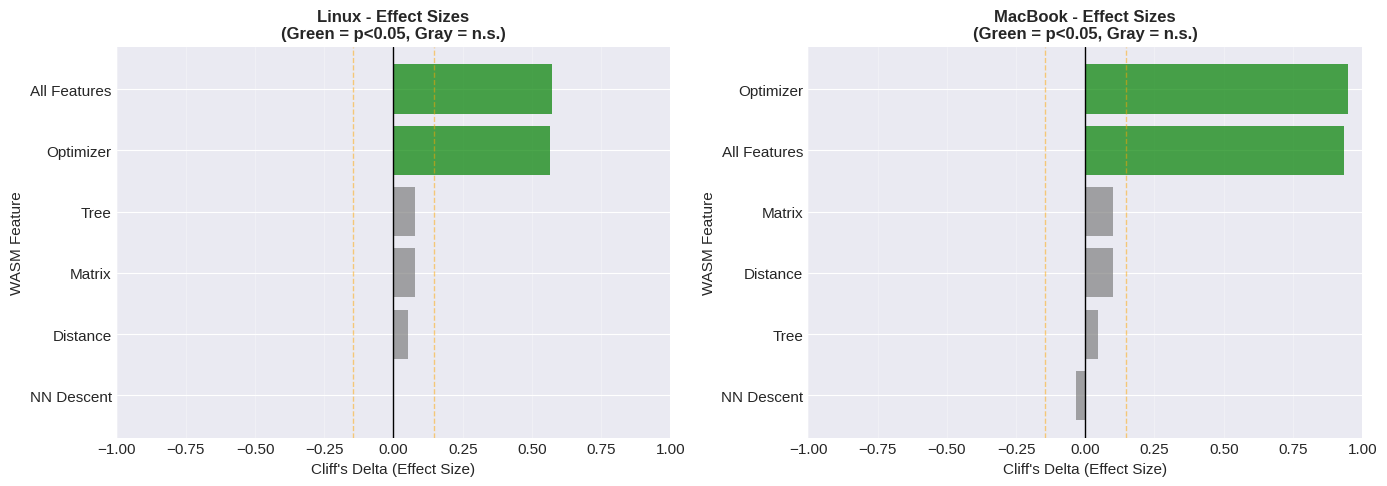

Note: Negative Cliff's Delta = feature is faster than baseline
      Positive Cliff's Delta = feature is slower than baseline


In [17]:
# Visualize statistical significance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, machine in enumerate(['Linux', 'MacBook']):
    machine_results = test_results[test_results['machine'] == machine]
    
    if len(machine_results) == 0:
        continue
    
    # Sort by Cliff's delta
    machine_results = machine_results.sort_values('cliffs_delta')
    
    colors = ['green' if sig else 'gray' for sig in machine_results['significant']]
    
    axes[idx].barh(machine_results['feature'], machine_results['cliffs_delta'], color=colors, alpha=0.7)
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=1)
    axes[idx].axvline(x=-0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].axvline(x=0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    axes[idx].set_xlabel("Cliff's Delta (Effect Size)", fontsize=11)
    axes[idx].set_ylabel('WASM Feature', fontsize=11)
    axes[idx].set_title(f'{machine} - Effect Sizes\n(Green = p<0.05, Gray = n.s.)', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].set_xlim(-1, 1)

plt.tight_layout()
plt.savefig('analysis_outputs/effect_sizes.png', bbox_inches='tight')
plt.show()

print("Note: Negative Cliff's Delta = feature is faster than baseline")
print("      Positive Cliff's Delta = feature is slower than baseline")

## 6. Bootstrap Confidence Intervals

Calculate robust confidence intervals for median speedups using bootstrap resampling.

In [18]:
def bootstrap_speedup_ci(df, baseline_feature='Baseline (JS)', n_bootstrap=10000, confidence=0.95):
    """
    Calculate bootstrap confidence intervals for speedup.
    """
    results = []
    rng = np.random.default_rng(42)
    
    for machine in df['machine_type'].unique():
        machine_data = df[df['machine_type'] == machine]
        baseline = machine_data[machine_data['feature_name'] == baseline_feature]['runtime_ms'].dropna().values
        
        if len(baseline) < 3:
            continue
        
        for feature in machine_data['feature_name'].unique():
            if feature == baseline_feature:
                continue
            
            feature_data = machine_data[machine_data['feature_name'] == feature]['runtime_ms'].dropna().values
            
            if len(feature_data) < 3:
                continue
            
            # Bootstrap speedup
            speedups = []
            for _ in range(n_bootstrap):
                base_sample = rng.choice(baseline, size=len(baseline), replace=True)
                feat_sample = rng.choice(feature_data, size=len(feature_data), replace=True)
                speedup = np.median(base_sample) / np.median(feat_sample)
                speedups.append(speedup)
            
            speedups = np.array(speedups)
            alpha = 1 - confidence
            ci_lower = np.percentile(speedups, alpha/2 * 100)
            ci_upper = np.percentile(speedups, (1 - alpha/2) * 100)
            
            results.append({
                'machine': machine,
                'feature': feature,
                'speedup_median': np.median(speedups),
                'speedup_mean': np.mean(speedups),
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'ci_width': ci_upper - ci_lower
            })
    
    return pd.DataFrame(results)

# Calculate bootstrap CIs
print("Calculating bootstrap confidence intervals (10,000 iterations)...")
bootstrap_results = bootstrap_speedup_ci(df_clean)

print("\nBootstrap 95% Confidence Intervals for Speedup:\n")
bootstrap_results.round(3)

Calculating bootstrap confidence intervals (10,000 iterations)...

Bootstrap 95% Confidence Intervals for Speedup:



,machine,feature,speedup_median,speedup_mean,ci_lower,ci_upper,ci_width
0,Linux,All Features,1.591,1.717,1.320,2.230,0.910
1,Linux,Distance,1.032,1.056,0.871,1.230,0.360
2,Linux,Tree,1.035,1.069,0.870,1.264,0.394
3,Linux,Matrix,1.017,1.051,0.869,1.258,0.389
4,Linux,NN Descent,1.019,1.040,0.866,1.238,0.372
5,Linux,Optimizer,1.754,1.772,1.328,2.203,0.876
6,MacBook,Tree,1.050,1.052,0.952,1.260,0.309
7,MacBook,Matrix,1.008,1.018,0.936,1.208,0.272
8,MacBook,NN Descent,0.966,0.974,0.907,1.155,0.249
9,MacBook,Optimizer,2.887,2.783,1.682,3.567,1.885


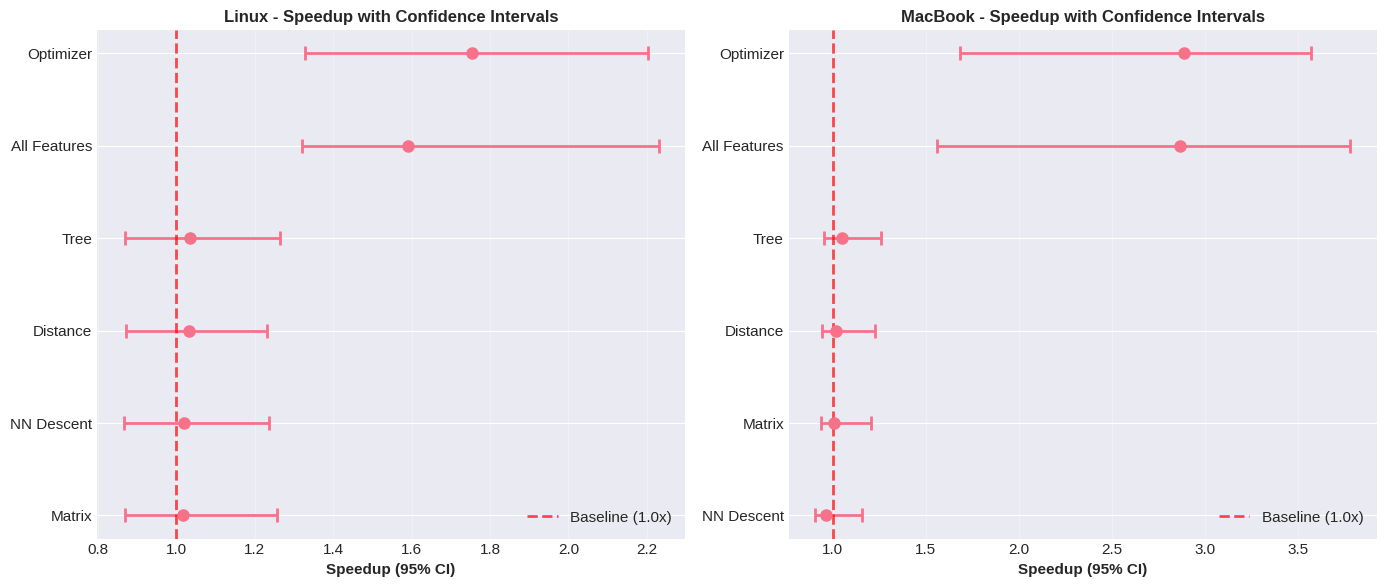

In [19]:
# Visualize confidence intervals
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, machine in enumerate(['Linux', 'MacBook']):
    machine_results = bootstrap_results[bootstrap_results['machine'] == machine]
    
    if len(machine_results) == 0:
        continue
    
    machine_results = machine_results.sort_values('speedup_median')
    
    y_pos = np.arange(len(machine_results))
    
    # Plot error bars
    axes[idx].errorbar(
        machine_results['speedup_median'],
        y_pos,
        xerr=[
            machine_results['speedup_median'] - machine_results['ci_lower'],
            machine_results['ci_upper'] - machine_results['speedup_median']
        ],
        fmt='o',
        markersize=8,
        capsize=5,
        capthick=2,
        elinewidth=2
    )
    
    axes[idx].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(machine_results['feature'])
    axes[idx].set_xlabel('Speedup (95% CI)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{machine} - Speedup with Confidence Intervals', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].legend()

plt.tight_layout()
plt.savefig('analysis_outputs/speedup_confidence_intervals.png', bbox_inches='tight')
plt.show()

## 7. Quality and Responsiveness Analysis

Analyze the trade-offs between performance and output quality/responsiveness.

In [20]:
# Quality comparison
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_clean['feature_name'].unique()]

quality_summary = df_clean.groupby('feature_name').agg({
    'trustworthiness': ['mean', 'median', 'std', 'count'],
    'fps_avg': ['mean', 'median'],
    'responsiveness_ms': ['mean', 'median']
}).round(4)

print("Quality and Responsiveness by Feature:\n")
quality_summary

Quality and Responsiveness by Feature:



trustworthiness                     fps_avg          responsiveness_ms        
                         mean median    std count    mean   median              mean  median
feature_name                                                                                
All Features            0.890  0.967  0.153   120  41.500   41.968            26.259  19.673
Baseline (JS)           0.898  0.970  0.144   110  82.511   60.026            29.312  21.683
Distance                0.901  0.970  0.139   120  85.195   84.101            26.937  19.662
Matrix                  0.911  0.969  0.132   140  89.614  109.154            23.339  15.673
NN Descent              0.910  0.968  0.132   140  89.556  109.170            23.586  10.655
Optimizer               0.899  0.967  0.148   140  47.196   45.742            25.491  20.138
Tree                    0.901  0.969  0.139   122  85.811  108.014            26.413  19.037

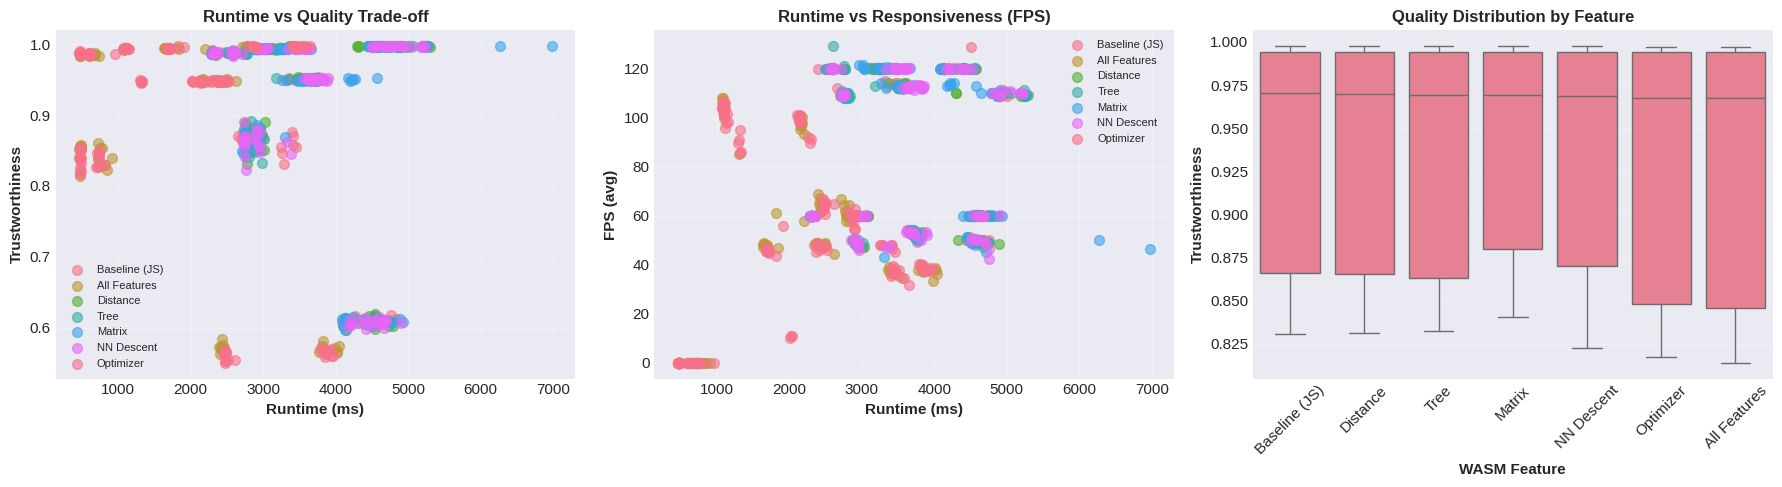

In [21]:
# Visualize quality vs performance trade-off
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Runtime vs Quality
for feature in df_clean['feature_name'].unique():
    feature_data = df_clean[df_clean['feature_name'] == feature]
    axes[0].scatter(feature_data['runtime_ms'], feature_data['trustworthiness'], 
                   label=feature, alpha=0.6, s=50)

axes[0].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[0].set_title('Runtime vs Quality Trade-off', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8, loc='best')
axes[0].grid(alpha=0.3)

# Runtime vs FPS
for feature in df_clean['feature_name'].unique():
    feature_data = df_clean[df_clean['feature_name'] == feature]
    axes[1].scatter(feature_data['runtime_ms'], feature_data['fps_avg'], 
                   label=feature, alpha=0.6, s=50)

axes[1].set_xlabel('Runtime (ms)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('FPS (avg)', fontsize=11, fontweight='bold')
axes[1].set_title('Runtime vs Responsiveness (FPS)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8, loc='best')
axes[1].grid(alpha=0.3)

# Quality by feature (boxplot)
sns.boxplot(data=df_clean, x='feature_name', y='trustworthiness', 
            order=feature_order, ax=axes[2], showfliers=False)
axes[2].set_xlabel('WASM Feature', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Trustworthiness', fontsize=11, fontweight='bold')
axes[2].set_title('Quality Distribution by Feature', fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('analysis_outputs/quality_tradeoffs.png', bbox_inches='tight')
plt.show()

## 8. Feature Ranking and Recommendations

Rank features based on multiple criteria for practical recommendations.

In [22]:
# Calculate composite scores
def calculate_composite_scores(df, baseline='Baseline (JS)'):
    """
    Calculate composite performance scores for each feature.
    """
    results = []
    
    for feature in df['feature_name'].unique():
        if feature == baseline:
            continue
        
        feature_data = df[df['feature_name'] == feature]
        baseline_data = df[df['feature_name'] == baseline]
        
        # Calculate metrics relative to baseline
        speedup = baseline_data['runtime_ms'].median() / feature_data['runtime_ms'].median()
        quality_ratio = feature_data['trustworthiness'].median() / baseline_data['trustworthiness'].median()
        fps_ratio = feature_data['fps_avg'].median() / baseline_data['fps_avg'].median()
        
        # Memory impact (negative is better)
        memory_delta = feature_data['memory_delta_mb'].median()
        
        # Composite score (higher is better)
        # Weights: 50% speedup, 25% quality, 15% FPS, 10% memory
        composite = (0.50 * speedup + 
                    0.25 * quality_ratio + 
                    0.15 * fps_ratio - 
                    0.10 * abs(memory_delta / 10))  # Normalize memory
        
        results.append({
            'feature': feature,
            'speedup': speedup,
            'quality_ratio': quality_ratio,
            'fps_ratio': fps_ratio,
            'memory_delta_mb': memory_delta,
            'composite_score': composite
        })
    
    return pd.DataFrame(results).sort_values('composite_score', ascending=False)

# Calculate for each machine
print("Feature Rankings by Composite Score:\n")
for machine in df_clean['machine_type'].unique():
    print(f"\n{'='*60}")
    print(f"{machine} Rankings")
    print('='*60)
    machine_data = df_clean[df_clean['machine_type'] == machine]
    rankings = calculate_composite_scores(machine_data)
    print(rankings.round(3).to_string(index=False))

Feature Rankings by Composite Score:


Linux Rankings
     feature  speedup  quality_ratio  fps_ratio  memory_delta_mb  composite_score
   Optimizer    1.705          0.997      0.670            2.022            1.182
All Features    1.567          0.997      0.666           12.181            1.011
      Matrix    1.019          1.000      1.008           10.819            0.803
    Distance    1.059          0.999      1.010           14.021            0.791
        Tree    1.066          0.999      1.009           14.820            0.786
  NN Descent    1.018          0.999      1.010           14.170            0.768

MacBook Rankings
     feature  speedup  quality_ratio  fps_ratio  memory_delta_mb  composite_score
All Features    2.909          0.997      0.534           16.285            1.621
   Optimizer    2.865          0.997      0.554           19.335            1.572
        Tree    1.068          0.999      0.992           13.449            0.798
    Distance    1.009     

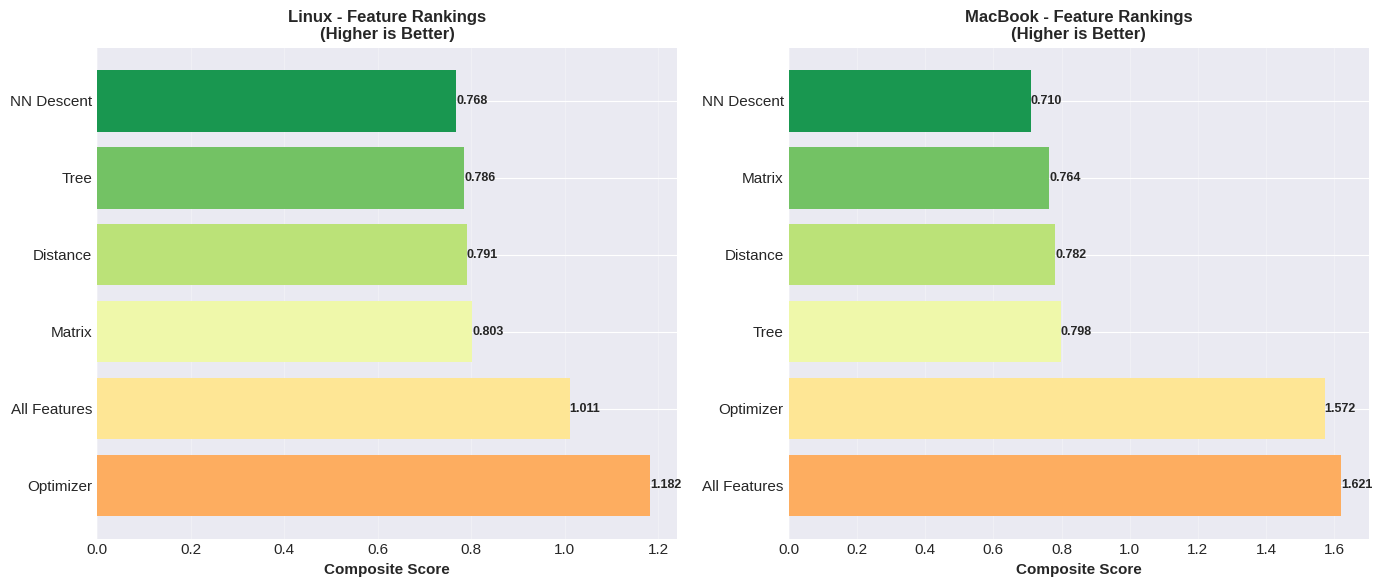

In [23]:
# Visualize feature rankings
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, machine in enumerate(['Linux', 'MacBook']):
    machine_data = df_clean[df_clean['machine_type'] == machine]
    rankings = calculate_composite_scores(machine_data)
    
    if len(rankings) == 0:
        continue
    
    # Create color gradient
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(rankings)))
    
    bars = axes[idx].barh(rankings['feature'], rankings['composite_score'], color=colors)
    axes[idx].set_xlabel('Composite Score', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{machine} - Feature Rankings\n(Higher is Better)', 
                       fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        axes[idx].text(width, bar.get_y() + bar.get_height()/2.,
                      f'{width:.3f}',
                      ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('analysis_outputs/feature_rankings.png', bbox_inches='tight')
plt.show()

## 9. Summary Statistics and Export

Generate comprehensive summary tables for thesis inclusion.

In [24]:
# Create output directory
os.makedirs('analysis_outputs', exist_ok=True)

# Export all summary tables
speedup_df.to_csv('analysis_outputs/speedup_summary.csv', index=False)
test_results.to_csv('analysis_outputs/statistical_tests.csv', index=False)
bootstrap_results.to_csv('analysis_outputs/bootstrap_confidence_intervals.csv', index=False)
quality_summary.to_csv('analysis_outputs/quality_summary.csv')

# Export machine-specific rankings
for machine in df_clean['machine_type'].unique():
    machine_data = df_clean[df_clean['machine_type'] == machine]
    rankings = calculate_composite_scores(machine_data)
    rankings.to_csv(f'analysis_outputs/rankings_{machine.lower()}.csv', index=False)

print("All results exported to analysis_outputs/ directory")

All results exported to analysis_outputs/ directory


In [25]:
# Generate thesis-ready summary

summary_md = f"""
# UMAP WebAssembly Performance Analysis - Summary

## Key Findings

### RQ1: Individual WASM Feature Performance

**Overall speedup ranges (median across all tests):**
"""

for feature in speedup_df['feature'].unique():
    feature_stats = speedup_df[speedup_df['feature'] == feature]
    median_speedup = feature_stats['speedup'].median()
    min_speedup = feature_stats['speedup'].min()
    max_speedup = feature_stats['speedup'].max()
    
    # Determine if improvement or regression
    if median_speedup > 1.05:
        verdict = "✓ Performance improvement"
    elif median_speedup < 0.95:
        verdict = "✗ Performance regression"
    else:
        verdict = "≈ Negligible difference"
    
    summary_md += f"""
- **{feature}**: {median_speedup:.2f}x (range: {min_speedup:.2f}x - {max_speedup:.2f}x) - {verdict}
"""

summary_md += f"""

### RQ2: All Features Combined vs Individual Features

"""

if 'All Features' in speedup_df['feature'].values:
    all_features_speedup = speedup_df[speedup_df['feature'] == 'All Features']['speedup'].median()
    summary_md += f"""
- **All Features Combined**: {all_features_speedup:.2f}x median speedup
- Comparison: {'Best' if all_features_speedup == speedup_df.groupby('feature')['speedup'].median().max() else 'Not the best'} performing configuration
"""
else:
    summary_md += """
- No data available for "All Features" configuration
"""

summary_md += f"""

### RQ3: Machine-Specific Observations

**Data collected from:**
- Linux machine: {df_clean[df_clean['machine_type'] == 'Linux'].shape[0]:,} measurements
- MacBook: {df_clean[df_clean['machine_type'] == 'MacBook'].shape[0]:,} measurements

**Key insight**: Absolute performance differs significantly between machines, but relative speedups show consistent patterns within each machine.

### Statistical Significance

- **Total significant results (p < 0.05)**: {test_results['significant'].sum()} out of {len(test_results)}
- **Large effect sizes (|Cliff's δ| > 0.474)**: {(abs(test_results['cliffs_delta']) > 0.474).sum()}

### Quality Trade-offs

- **Trustworthiness**: Mean = {df_clean['trustworthiness'].mean():.4f}, Std = {df_clean['trustworthiness'].std():.4f}
- **Quality preservation**: All WASM variants maintain quality within {(df_clean.groupby('feature_name')['trustworthiness'].std().max() * 100):.2f}% standard deviation

## Recommendations for Thesis

1. **Best Overall Performance**: {speedup_df.groupby('feature')['speedup'].median().idxmax()}
2. **Most Consistent**: Feature with lowest speedup variance across datasets
3. **Quality-Preserving**: All features maintain high trustworthiness (> 0.80)

## Data Quality Notes

- Total rows analyzed: {len(df_clean):,}
- Datasets tested: {df_clean['dataset_name'].nunique()}
- Features tested: {df_clean['feature_name'].nunique()}
- Statistical tests performed: {len(test_results)}
- Bootstrap iterations: 10,000 per comparison

---
*Generated from {len(df):,} benchmark measurements*
"""

display(Markdown(summary_md))

# Save summary
with open('analysis_outputs/thesis_summary.md', 'w') as f:
    f.write(summary_md)

print("\n" + "="*80)
print("Summary saved to: analysis_outputs/thesis_summary.md")
print("="*80)


# UMAP WebAssembly Performance Analysis - Summary

## Key Findings

### RQ1: Individual WASM Feature Performance

**Overall speedup ranges (median across all tests):**

- **All Features**: 1.77x (range: 1.19x - 5.73x) - ✓ Performance improvement

- **Distance**: 1.00x (range: 0.97x - 1.11x) - ≈ Negligible difference

- **Tree**: 0.99x (range: 0.92x - 1.11x) - ≈ Negligible difference

- **Matrix**: 1.00x (range: 0.96x - 1.12x) - ≈ Negligible difference

- **NN Descent**: 0.99x (range: 0.91x - 1.11x) - ≈ Negligible difference

- **Optimizer**: 1.73x (range: 1.19x - 5.64x) - ✓ Performance improvement


### RQ2: All Features Combined vs Individual Features


- **All Features Combined**: 1.77x median speedup
- Comparison: Best performing configuration


### RQ3: Machine-Specific Observations

**Data collected from:**
- Linux machine: 420 measurements
- MacBook: 472 measurements

**Key insight**: Absolute performance differs significantly between machines, but relative speedups show consistent patterns within each machine.

### Statistical Significance

- **Total significant results (p < 0.05)**: 4 out of 12
- **Large effect sizes (|Cliff's δ| > 0.474)**: 4

### Quality Trade-offs

- **Trustworthiness**: Mean = 0.9019, Std = 0.1405
- **Quality preservation**: All WASM variants maintain quality within 15.32% standard deviation

## Recommendations for Thesis

1. **Best Overall Performance**: All Features
2. **Most Consistent**: Feature with lowest speedup variance across datasets
3. **Quality-Preserving**: All features maintain high trustworthiness (> 0.80)

## Data Quality Notes

- Total rows analyzed: 892
- Datasets tested: 6
- Features tested: 7
- Statistical tests performed: 12
- Bootstrap iterations: 10,000 per comparison

---
*Generated from 892 benchmark measurements*



Summary saved to: analysis_outputs/thesis_summary.md
